# Setup

In [1]:
import os
import random
import datetime
import importlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from numpy.linalg import cond
# Matrixlib
from matrixlib import preconditioning as prec
from matrixlib.core import MatrixData, ValueProperties, BlockProperties

#import CNN
import CNN.models
import CNN.training
import CNN.evaluation

# Check wd
current_base_path = os.getcwd()
print(f"Path to current working directory: {current_base_path}")
!whoami

Path to current working directory: C:\Projects\Dev\opencampus-preconditioner-ai-project
storbror\t


In [2]:
# !pip install tensorflow-gpu==2.3.0

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
# %%capture
# !pip install numpy==1.23.1 Pillow==9.2.0 importlib-metadata==4.11.3 matplotlib==3.5.2 scikit-learn==1.1.1 tensorboard==2.9.1 jupyter==1.0.0 ipykernel==6.9.1 seaborn==0.13.2

In [5]:
# import sys
# import os
# 
# # Add the project directory to the Python path
# sys.path.append('/home/azureuser/projects/opencampus-preconditioner-ai-project')
# 
# # Change the working directory to the project directory
# os.chdir('/home/azureuser/projects/opencampus-preconditioner-ai-project')
# print(os.getcwd())  # Verify the change
# tf.config.list_physical_devices('GPU') # Verify the GPU is available

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [6]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 100
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42
VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

initialized        data vectors of size    100 x  64 x  64 =    409600 with a memory usage of   1.562 MiB
initialized  data start vectors of size    100 x  64       =      6400 with a memory usage of   0.006 MiB
initialized noise start vectors of size    100 x  64       =      6400 with a memory usage of   0.006 MiB
initialized        band vectors of size    100 x  64 x  10 =     64000 with a memory usage of   0.513 MiB
--------------------------------------------------------------------------------
instantiation rng generators...
generating matrices...
invalid matrices: 0
determinant abs-value range: [0.09879070520401001, 1241520.875]


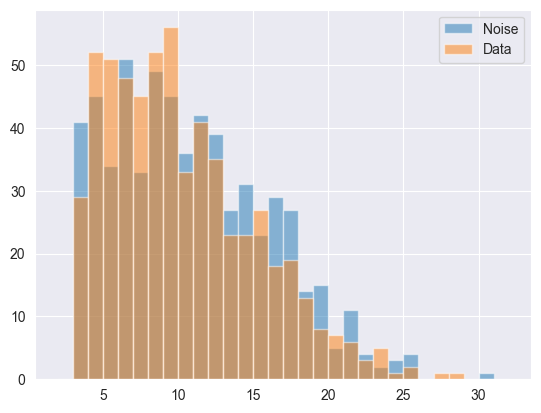

duration: 0.35 seconds


In [7]:
    # Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=True
    )

In [8]:
bands = test_data.bands.reshape(NUMBER_OF_MATRICES, (DIAGONAL_BAND_RADIUS* 2 + 1), MATRIX_DIM, 1)
bands = np.nan_to_num(bands) # replace NaNs with 0s
labels = test_data.tdata_blk_starts
print(f"Matrix Bands Shape: {bands.shape}, Matrix Labels Shape: {labels.shape}")

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((bands, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Create test matrices and labels
test_matrices = test_data.matrices[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Verify Shape
print(f"Test Matrices Shape: {test_matrices.shape}, Test Labels Shape: {test_labels.shape}")
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

# Verifiy datasets
print(train_dataset)
print(val_dataset)
print(test_dataset)

Matrix Bands Shape: (100, 21, 64, 1), Matrix Labels Shape: (100, 64)
Test Matrices Shape: (10, 64, 64), Test Labels Shape: (10, 64)
Train size: 80, Val size: 10, Test size: 10
<_ShuffleDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>


# Training
run tensorboard --logdir logs to launch tensorboard

In [ ]:
importlib.reload(CNN.training)
importlib.reload(CNN.models)

# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)
num_epochs = 2

# Create log dir
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print("Files in log directory:", os.listdir(log_dir))

def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seeds()

# Compile Model
model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Start Training Loop
trained_model, train_losses, val_losses = CNN.training.train_model(
    model=model,
    train_dataset=train_dataset.batch(2),  # Adjust when connected to vm
    val_dataset=val_dataset.batch(2),
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_dir=log_dir
)

In [ ]:
# Plot losses
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses.

    Args:
        train_losses (list of float): List of training losses per epoch.
        val_losses (list of float): List of validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

# Evaluation

In [ ]:
# Evaluate the model on the test set
evaluation_results = CNN.evaluation.evaluate_model(
    model=trained_model,
    test_dataset=test_dataset.batch(2),
    loss_fn=loss_fn
)

In [ ]:
importlib.reload(CNN.models)
# Restore weights from best run
new_model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
new_model.build(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
new_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# best_checkpoint_file = os.path.join(log_dir, "baseline_final.weights.h5")  
new_model.load_weights("/home/moonchild/PycharmProjects/opencampus-preconditioner-ai-project/logs/fit/20240622-141850/model.20-1.2401.weights.h5")

# Log model weights after loading
print("Model weights after loading:")
print(new_model.get_weights())

# Evaluate the restored model
new_results = CNN.evaluation.evaluate_model(
    model=new_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

# Prediction

In [ ]:
# Extract test matrices and labels from dataset
test_bands = bands[train_size + val_size:]
print(f"labels[0] = {labels[train_size + val_size]}")
test_labels = labels[train_size + val_size:]
print(f"test_labels[0] = {test_labels[0]}")
# Make Predictions
test_predictions = trained_model.predict(test_dataset.batch(2))

# Convert to Binary
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

# Calculate Metrics
overall_accuracy = (binary_predictions == test_labels).mean()
print("Overall Accuracy:")
print(overall_accuracy)

In [ ]:
print(test_matrices.shape)
print(test_bands.shape)
print(binary_predictions.shape)

for i in range(min(10, test_matrices.shape[0])):
    print(f"Condition number of matrix {i}: {np.linalg.cond(test_matrices[i])}")

for i in range(min(10, A.shape[0])):
    print(f"Condition number of prepared matrix {i}: {np.linalg.cond(A[i])}")

# plot condition numbers 
plt.figure(figsize=(10, 6))
plt.plot([np.linalg.cond(test_matrices[i]) for i in range(test_matrices.shape[0])], label='Original Matrix')
plt.plot([np.linalg.cond(A[i]) for i in range(A.shape[0])], label='Prepared Matrix')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
plt.show()


# Create Preconditioner from predicted block starts
### 1. Form Blocks from Predictions
### 2. Invert Blocks (ensure non-singularity)
### 3. Create Block Diagonal Matrix



# Run GMRES Solver with and without Precodnitioner

In [70]:
# Define inputs
importlib.reload(prec)
A = np.array([prec.prepare_matrix(test_matrices[i]) for i in range(test_matrices.shape[0])])
# A = test_matrices
# precs = prec.block_jacobi_preconditioner_from_predictions(A, test_labels)
precs = prec.block_jacobi_preconditioner_from_predictions(test_matrices, test_labels)
b = np.ones((A.shape[0], A.shape[1]))

# Check Condition Numbers
print(f"Condition number original: {cond(test_matrices[1])}")
print(f"Condition number prepared: {cond(A[1])}")
print(f"Condition number preconditioner: {cond(precs[1])}")
print(f"Condition number Product: {cond(np.matmul(A[1], precs[1]))}")
print(f"Frobenius norm of difference between preconditioner and inverse: {np.linalg.norm(precs[1] - np.linalg.inv(A[1]))}")

Condition number original: 160.27406311035156
Condition number prepared: 500827.0625
Condition number preconditioner: 51.56100845336914
Condition number Product: 8710993.0
Frobenius norm of difference between preconditioner and inverse: 9776.3203125


In [71]:
# Define inputs
importlib.reload(prec)
# Solve without preconditioner
x_no_prec, info_no_prec, iters_no_prec, residuals_no_prec = prec.solve_with_gmres_monitored(A, b)
# x_no_prec, info_no_prec, iters_no_prec, residuals_no_prec = prec.solve_with_gmres_monitored(test_matrices, b)
# Solve with block Jacobi preconditioner
x_prec, info_prec, iters_prec, residuals_prec = prec.solve_with_gmres_monitored(A, b, M=precs)

# Calculate and print the relative residuals
rel_residuals_no_prec = [np.linalg.norm(b[i] - A[i] @ x_no_prec[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]
rel_residuals_prec = [np.linalg.norm(b[i] - A[i] @ x_prec[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]

print("\nRelative residual:")
print(f"  Without preconditioner: min={np.min(rel_residuals_no_prec):.2e}, max={np.max(rel_residuals_no_prec):.2e}, mean={np.mean(rel_residuals_no_prec):.2e}")
print(f"  With preconditioner: min={np.min(rel_residuals_prec):.2e}, max={np.max(rel_residuals_prec):.2e}, mean={np.mean(rel_residuals_prec):.2e}")

Without preconditioner:
  Converged: 10 out of 10
  Average iterations: 1588.70
  iterations: [ 2023   180   233   352 10345   422   234   783   832   483]
With preconditioner:
  Converged: 10 out of 10
  Average iterations: 1006.30
  iterations: [1145  166  260  305 5463  328  238  421  958  779]

Relative residual:
  Without preconditioner: min=9.94e-04, max=1.00e-03, mean=9.99e-04
  With preconditioner: min=4.95e-04, max=9.99e-04, mean=9.25e-04


TypeError: 'Axes' object is not subscriptable

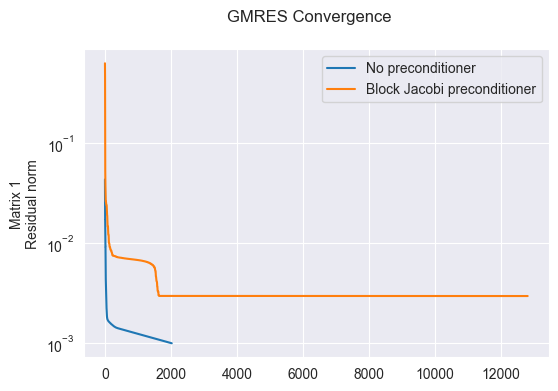

In [35]:
# Plot convergence for a few matrices
num_plots = min(1, A.shape[0])
fig, axes = plt.subplots(num_plots, 1, figsize=(6, 4*num_plots), sharex=True)
fig.suptitle('GMRES Convergence')

for i in range(num_plots):
    ax = axes[i] if num_plots > 1 else axes
    ax.semilogy(residuals_no_prec[i], label='No preconditioner')
    ax.semilogy(residuals_prec[i], label='Block Jacobi preconditioner')
    ax.set_ylabel(f'Matrix {i+1}\nResidual norm')
    ax.legend()

# axes[-1].set_xlabel('Iteration')
plt.tight_layout()
plt.show()

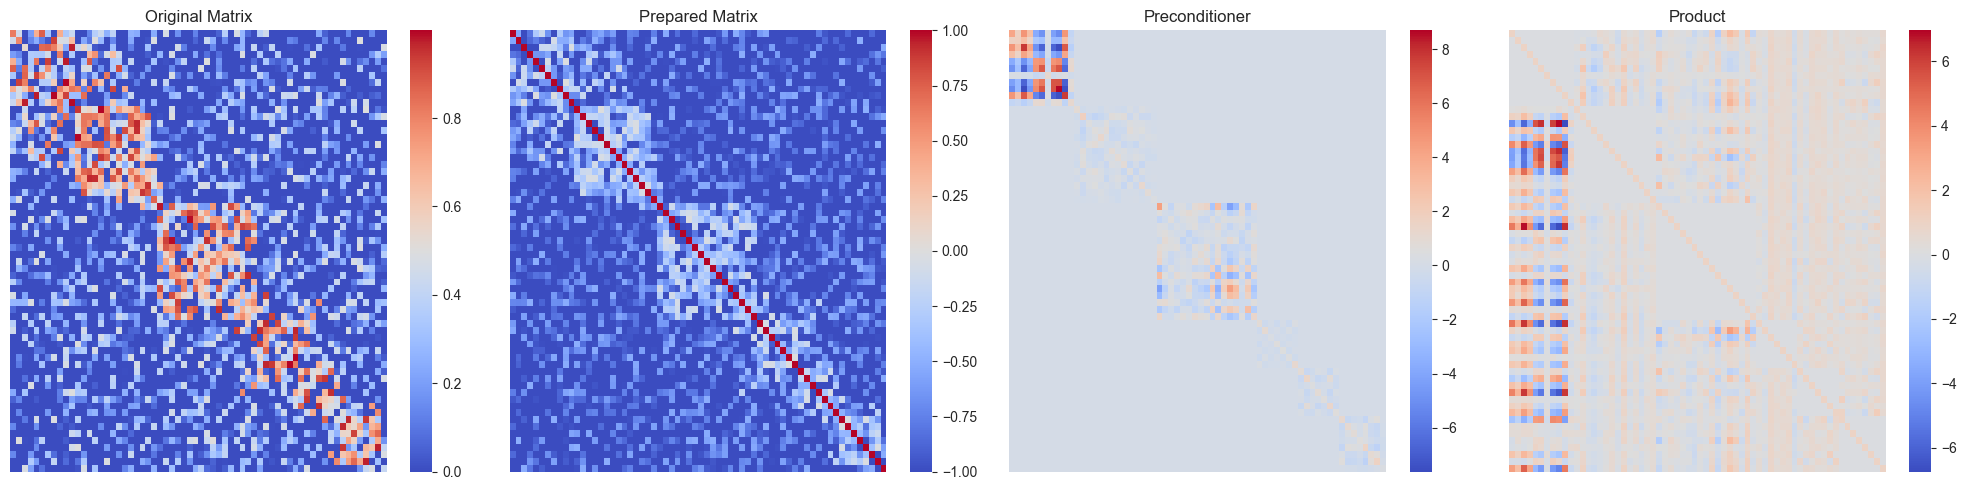

In [32]:
# Function to plot matrices
def plot_matrices(matrices: List[np.ndarray], titles: List[str], colorbar: str = VALUE_COLORBAR) -> None:
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 5))

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        sns.heatmap(matrix, cmap=colorbar, ax=ax, cbar=True)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
# Plot matrices
plot_matrices([test_matrices[0], A[0], precs[0], np.matmul(A[0], precs[0])], ['Original Matrix', 'Prepared Matrix', 'Preconditioner', 'Product'], colorbar='coolwarm')

In [13]:
np.linalg.det(test_matrices[0])

1247.898

In [14]:
# Check condition number
from numpy.linalg import cond

print(f"Condition number original: {cond(test_matrices[0])}")
print(f"Condition number prepared: {cond(A[0])}")
print(f"Condition number preconditioner: {cond(precs[0])}")
print(f"Frobenius norm of difference between preconditioner and inverse: {np.linalg.norm(precs[0] - np.linalg.inv(A[0]))}")
#residual = np.linalg.norm(b_example - A_example @ x_prec)
#print(f"Residual after preconditioned GMRES: {residual}")

Condition number original: 498.46612548828125
Condition number prepared: 286.57098388671875
Condition number preconditioner: 91.85004425048828
Frobenius norm of difference between preconditioner and inverse: 35.19872283935547
